#Quick look at Higher Order Non-symplectic propagation in Synergia

This notebook will focus on the higher order (non-symplectic) Taylor maps constructed by Synergia. In the same vein as the 1st Order Symplectic Propagation notebook, we will stick to a basic lattice example and compare the beam and single particle behavior with different maps and lattice variations.

In [1]:
%load_ext watermark
%load_ext autoreload
%autoreload 2

In [3]:
%watermark -d -v -a "Nathan Cook"

Nathan Cook 15/07/2015 

CPython 2.7.10
IPython 3.1.0


In [2]:
import sys, os
import synergia
from mpi4py import MPI
import synergia_workflow

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

###3rd order - Load lattice and construct map

In [3]:
#load lattice
lattice = synergia.lattice.Mad8_reader().get_lattice("model16s", "/Users/ncook/Synergia_Tests/lattices/foborodobo_NL.lat")

length = lattice.get_length()
ref = lattice.get_reference_particle() #reference particle
ds = 0.01
nsteps = int(length/ds) +1 #calculate # of steps to take per turn
nsteps_per_element = nsteps/len(lattice.get_elements()) #not this isn't using future division, so returns int

In [4]:
from base_diagnostics import workflow

name = 'model-S-strong'
order = 3
outputdir = 'order_'+str(order)+'_'+name

opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
workflow.make_path(outputdir)

lattice_simulator = synergia.simulation.Lattice_simulator(lattice,
                                                              opts.map_order)
stepper= synergia.simulation.Independent_stepper(lattice, opts.map_order, opts.steps)

In [5]:
from base_diagnostics import latticework

#define a secondary lattice_simulator for this work

#stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
new_lattice_simulator = stepper.get_lattice_simulator()

x_tune0, y_tune0 = new_lattice_simulator.get_both_tunes()
x_tune1 = 0.33 #place on resonance
y_tune1 = y_tune0 #keep the same if possible
tune_tol = 1.0e-7; #need to define a tolerance for the fit


#specify a set of magnets to be adjusted
f_quads, d_quads = latticework.get_fd_quads(lattice)

#use these magnets to adjust tune to specified final values
new_lattice_simulator.adjust_tunes(x_tune1,y_tune1,f_quads,d_quads,tune_tol)

#update lattice_simulator and get new lattice
new_lattice_simulator.update()
new_lattice = new_lattice_simulator.get_lattice()

#Force define original lattice simulator
lattice = synergia.lattice.Mad8_reader().get_lattice("model16s", "/Users/ncook/Synergia_Tests/lattices/foborodobo_NL.lat")
stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()


#Print stuff for original lattice
print str(lattice_simulator.get_horizontal_tune()) + " is the original x-tune"
f_quads, d_quads = latticework.get_fd_quads(lattice)
latticework.print_strengths(f_quads)
latticework.print_strengths(d_quads)

#Print stuff for new re-tuned lattice
print str(new_lattice_simulator.get_horizontal_tune()) + " is the new x-tune"
new_f_quads, new_d_quads = latticework.get_fd_quads(new_lattice)
latticework.print_strengths(new_f_quads)
latticework.print_strengths(new_d_quads)

0.0920106680371 is the original x-tune
f K: 0.714285714286
d K: -0.714285714286
0.329999998897 is the new x-tune
f K: 0.761214567067
d K: -0.729172681136


###3rd Order - Run the simulation

In [6]:
stepper= synergia.simulation.Independent_stepper(new_lattice, opts.map_order, opts.steps)

#Construct a matched bunch
myBunch = synergia.optics.generate_matched_bunch_transverse(
    new_lattice_simulator, opts.emitx, opts.emity, opts.stdz, 
    opts.dpop, opts.real_particles, 
    opts.macro_particles, opts.seed) 

#myBunch_2 = synergia.bunch.Bunch(new_lattice_simulator.get_lattice().get_reference_particle(),
#              num_macro_particles, num_real_particles, comm, z_period_length, bunch_index)
    
#Plot the bunch using my tools
#from base_diagnostics import pltbunch


# Define a bunch simulator
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

# Define a set of bunch diagnostics

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#tracking diagnostics - PER STEP
diagnostics = synergia.bunch.Diagnostics_track("track.h5", opts.tracked_particles, opts.output_dir)
#Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
bunch_simulator.add_per_step(diagnostics)

#particle diagnostics - PER TURN
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag)

In [9]:
#3rd order map- ~6s per turn for 1000 particles, ~2s per turn for 100 particles
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator, opts.turns, opts.maxturns, 
                     opts.verbosity)
#clean up files
workflow.cleanup(outputdir)

NameError: name 'cleanup' is not defined

###3rd Order - Single Particle Diagnostics

/Users/ncook/.virtualenvs/synergiaenv/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


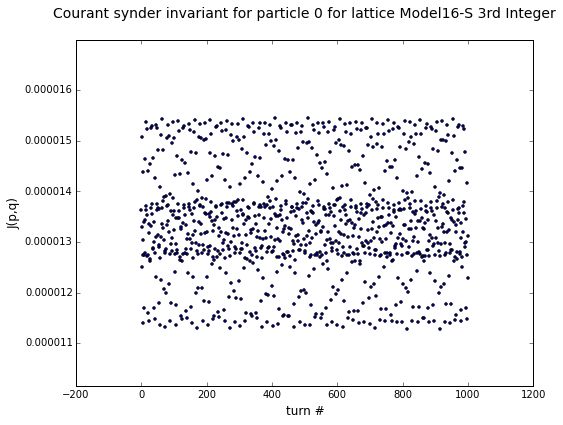

In [7]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16-S 3rd Integer'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.1
popts.lattice_simulator = new_lattice_simulator
popts.relpath = opts.output_dir


singleparticle.plot_Invariant(popts)

We see a very large spread in the single particle invariant, upwards of 10%, showing the clear break in preservation due to the resonance.

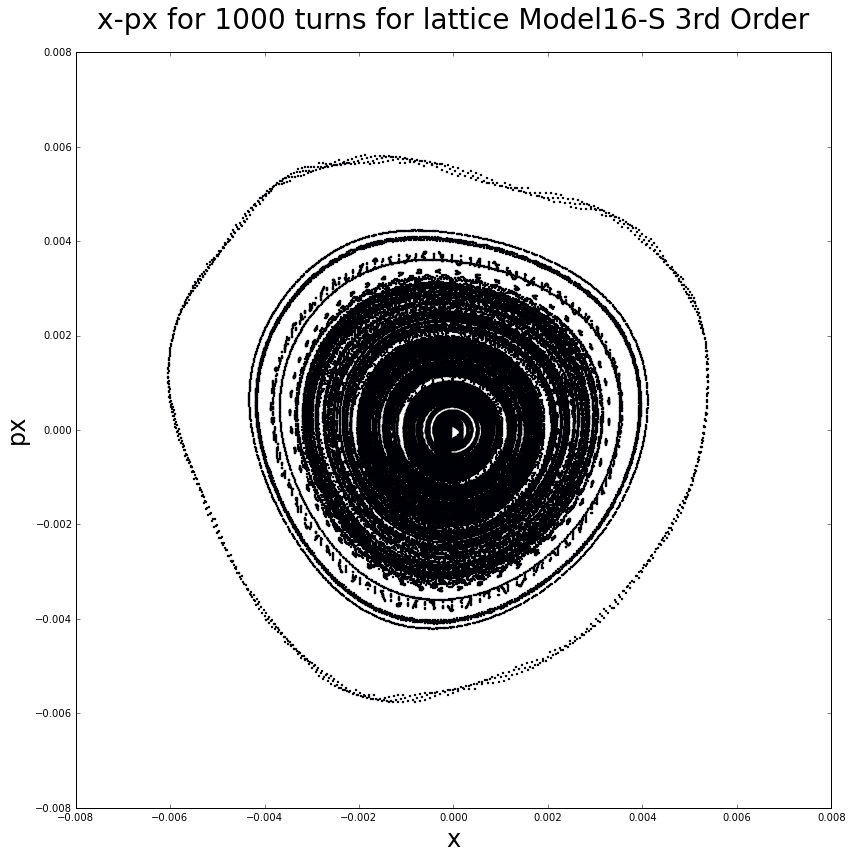

In [8]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16-S 3rd Order'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = new_lattice_simulator
popts.relpath = opts.output_dir

popts.save = True
popts.plots = ['x','px']
popts.num = 100
popts.scale = 2

singleparticle.plot_Poincare(popts)

With the 3rd order map we now see the development of a misshapen phase space.

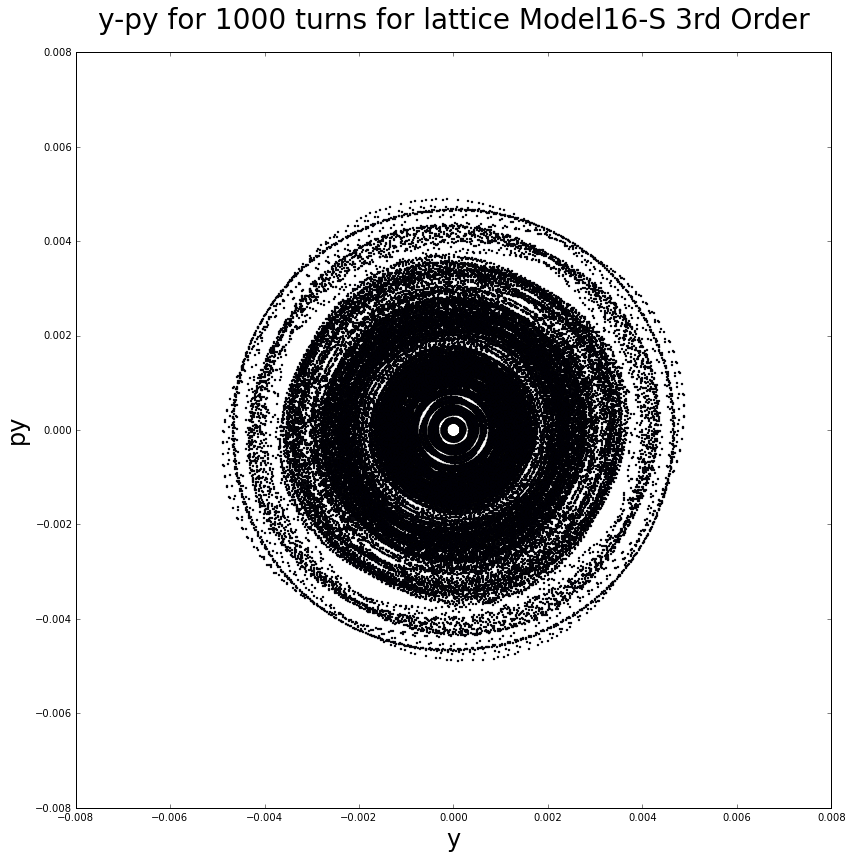

In [9]:
popts = options.Options()
popts.lattice_name = 'Model16-S 3rd Order'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = new_lattice_simulator
popts.relpath = opts.output_dir

popts.save = True
popts.plots = ['y','py']
popts.num = 100
popts.scale = 2

singleparticle.plot_Poincare(popts)

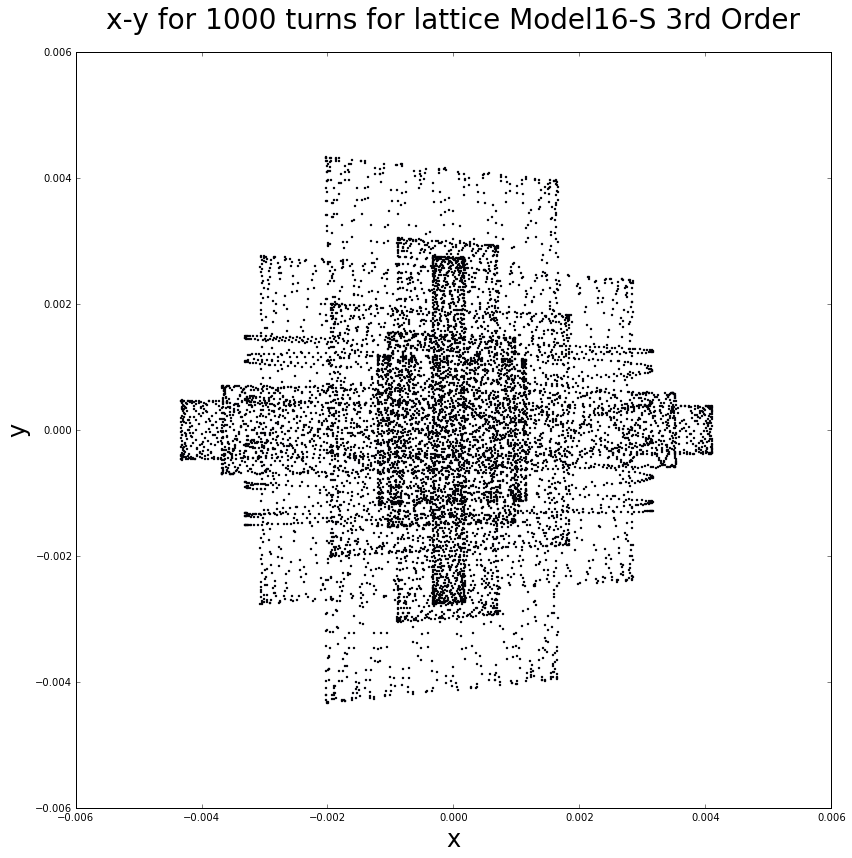

In [10]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16-S 3rd Order'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = new_lattice_simulator
popts.relpath = opts.output_dir

popts.save = True
popts.plots = ['x','y']
popts.num = 10
popts.scale = 2

singleparticle.plot_Poincare(popts)